In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import colors
import seaborn as sns
import statistics

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

ModuleNotFoundError: No module named 'pandas'

In [48]:
pd.options.display.float_format = '{:.2f}'.format

In [2]:
retail = pd.read_excel('data/orginal/orders.xlsx')


In [3]:
retail.head(3)

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name
0,262108413,SlcW7YT835JSzh22o7zRCA==,922274,406523,1,139000,2018-08-20 23:59:02,1698,تهران,9,تهران
1,262108413,SlcW7YT835JSzh22o7zRCA==,685868,435013,1,890000,2018-08-20 23:59:02,1698,تهران,9,تهران
2,262108353,NZidrSuPdqoG7RedrFakeA==,275077,163947,1,9890000,2018-08-20 23:58:39,1698,تهران,9,تهران


In [4]:
# New Attribute : Monetary

retail['Monetary']= retail['quantity']*retail['price']
rfm_m = retail.groupby('user_id')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['user_id', 'Monetary']
rfm_m.head()

,user_id,Monetary
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000
1,++HwHhPvBHtXEIN36fDT5w==,1414000
2,++IfjhhQ33j7i4NHdBUJkQ==,990000
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500
4,++XCbp2ChGJyYhM/fYWudg==,1150000


In [5]:
# New Attribute : Frequency

rfm_f = retail.groupby('user_id')['order_id'].nunique()

rfm_f = rfm_f.reset_index()
rfm_f.columns = ['user_id', 'Frequency']
rfm_f.head()

,user_id,Frequency
0,++2u4Q40bTeC0ZZDau1MIQ==,1
1,++HwHhPvBHtXEIN36fDT5w==,1
2,++IfjhhQ33j7i4NHdBUJkQ==,1
3,++KPSp+1ZC6KXlYAS8VcKg==,1
4,++XCbp2ChGJyYhM/fYWudg==,1


In [6]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['date'] = pd.to_datetime(retail['date'],format='%Y-%m-%d %H:%M:%S')

# Compute the maximum date to know the last transaction date
max_date = retail['date'].max()

# Compute the minimum date to know the last transaction date
min_date = retail['date'].min()

f"this df show orders for {max_date - min_date}"

'this df show orders for 8 days 17:39:43'

In [7]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['date']
retail.tail()


,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Monetary,Diff
199995,258838077,chbca7XuHDG/7OJPls3fNA==,494706,340247,1,40000,2018-08-12 06:21:26,1698,تهران,9,تهران,40000,8 days 17:37:36
199996,258838077,chbca7XuHDG/7OJPls3fNA==,823091,389988,1,325000,2018-08-12 06:21:26,1698,تهران,9,تهران,325000,8 days 17:37:36
199997,258838077,chbca7XuHDG/7OJPls3fNA==,483089,334477,1,1750000,2018-08-12 06:21:26,1698,تهران,9,تهران,1750000,8 days 17:37:36
199998,258838077,chbca7XuHDG/7OJPls3fNA==,1129695,640539,1,184000,2018-08-12 06:21:26,1698,تهران,9,تهران,184000,8 days 17:37:36
199999,258838041,OVCXfcaxQtqLzmy1U8A7eg==,1033353,568751,1,170000,2018-08-12 06:19:19,1442,بوکان,3,آذربایجان غربی,170000,8 days 17:39:43


In [8]:
# Compute last transaction date to get the recency of customers
rfm_r = retail.groupby('user_id')['Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.columns = ['user_id', 'Recency']
rfm_r['Recency'] = rfm_r['Recency'].dt.days
rfm_r.head()


,user_id,Recency
0,++2u4Q40bTeC0ZZDau1MIQ==,0
1,++HwHhPvBHtXEIN36fDT5w==,1
2,++IfjhhQ33j7i4NHdBUJkQ==,7
3,++KPSp+1ZC6KXlYAS8VcKg==,6
4,++XCbp2ChGJyYhM/fYWudg==,8


In [9]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='user_id', how='inner')
rfm = pd.merge(rfm, rfm_r, on='user_id', how='inner')

rfm.head()

,user_id,Monetary,Frequency,Recency
0,++2u4Q40bTeC0ZZDau1MIQ==,1082000,1,0
1,++HwHhPvBHtXEIN36fDT5w==,1414000,1,1
2,++IfjhhQ33j7i4NHdBUJkQ==,990000,1,7
3,++KPSp+1ZC6KXlYAS8VcKg==,1690500,1,6
4,++XCbp2ChGJyYhM/fYWudg==,1150000,1,8


In [10]:
# Removing (statistical) outliers for attribute
all_attributes = ['Monetary','Frequency','Recency']
for attribute in all_attributes:
    Q1 = rfm[attribute].quantile(0.05)
    Q3 = rfm[attribute].quantile(0.95)
    IQR = Q3 - Q1
    rfm = rfm[(rfm[attribute] >= Q1 - 1.5*IQR) & (rfm[attribute] <= Q3 + 1.5*IQR)]

In [11]:
rfm.shape

(55133, 4)

In [12]:
rfm = rfm[rfm['Frequency']>=2]
rfm.shape

(9928, 4)

In [13]:
rfm_df = rfm[all_attributes]

In [14]:
rfm_df.shape

(9928, 3)

,Monetary,Frequency,Recency
7,880000,2,5
8,7021000,2,0
14,19120000,3,1
38,7290000,2,0
39,1528800,2,3
...,...,...,...
56085,3183000,3,3
56087,2155000,2,7
56099,4981000,3,0
56100,1560000,3,6


In [15]:
# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(9928, 3)

(9928, 5)

# Building the Model


In [16]:
CLUSTERING = 3

In [17]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=CLUSTERING, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [18]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,user_id,Monetary,Frequency,Recency,Cluster_Id
7,++aFMHHDKluZF2DJXQ4VVg==,880000,2,5,1
8,++fz+vTHQnkgPIU4nFLwqg==,7021000,2,0,2
14,+/4x52C5GE58tU5a4oiIoA==,19120000,3,1,0
38,+0NLplvuXBK8B57SSP/BPw==,7290000,2,0,2
39,+0PlX9fbkOLljCIpz6XPLw==,1528800,2,3,2


In [63]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9928 entries, 7 to 56103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     9928 non-null   object
 1   Monetary    9928 non-null   int64 
 2   Frequency   9928 non-null   int64 
 3   Recency     9928 non-null   int64 
 4   Cluster_Id  9928 non-null   int32 
dtypes: int32(1), int64(3), object(1)
memory usage: 426.6+ KB


In [65]:
rfm.groupby('Cluster_Id').mean()

,Monetary,Frequency,Recency
Cluster_Id,,,
0,14858120.44,3.77,1.48
1,4781080.33,2.14,5.55
2,4318597.74,2.19,1.23


<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

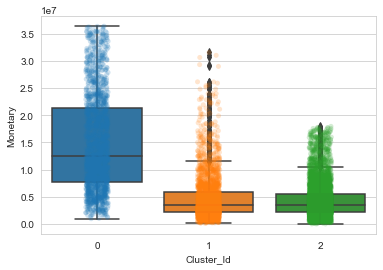

In [19]:
sns.set_style('whitegrid')
sns.boxplot(x='Cluster_Id',y='Monetary',data=rfm )
sns.stripplot(x="Cluster_Id", y="Monetary",data=rfm,   alpha=0.2 )

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

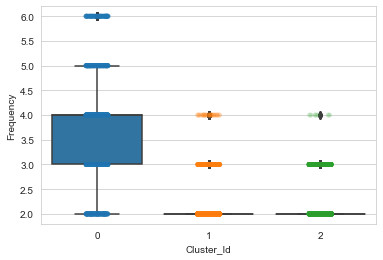

In [20]:
sns.set_style('whitegrid')
sns.boxplot(x='Cluster_Id',y='Frequency',data=rfm )
sns.stripplot(x="Cluster_Id", y="Frequency",data=rfm,   alpha=0.2 )

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

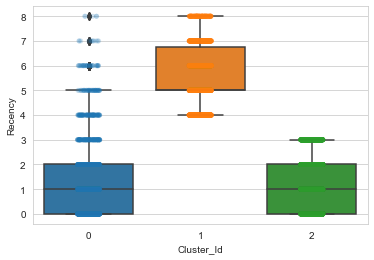

In [21]:
sns.set_style('whitegrid')
sns.boxplot(x='Cluster_Id',y='Recency',data=rfm )
sns.stripplot(x="Cluster_Id", y="Recency",data=rfm,   alpha=0.2 )

In [22]:
rfm['Cluster_Id'].value_counts()

2    5637
1    2602
0    1689
Name: Cluster_Id, dtype: int64

In [59]:
rfm.groupby('Cluster_Id').Monetary.mean()

Cluster_Id
0   14858120.44
1    4781080.33
2    4318597.74
Name: Monetary, dtype: float64

In [23]:
retail[retail['user_id'].isin(rfm[rfm['Cluster_Id']==0]['user_id'])].head(1)

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Monetary,Diff
0,262108413,SlcW7YT835JSzh22o7zRCA==,922274,406523,1,139000,2018-08-20 23:59:02,1698,تهران,9,تهران,139000,0 days


In [26]:
cluster_members = []

In [27]:
for i in range(CLUSTERING):
    cluster_members.append(retail[retail['user_id'].isin(rfm[rfm['Cluster_Id'] == i ]['user_id'])])

In [30]:
pivot_table = cluster_members[0].pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)
pivot_table

product_id,1482,2157,2854,3288,3914,4486,4822,5165,5256,5289,...,763143,763175,763202,763212,763278,763470,764412,765117,766245,767740
user_id,,,,,,,,,,,,,,,,,,,,,
+/4x52C5GE58tU5a4oiIoA==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+0Z8Z8H1GzgQNkXLT1XZOQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+2aNkBTZn8DfF2sk4heGpQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+4DlQFQ4veXWhw9z1aGEFw==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
+EukDLC1vahipDOtWd8ApQ==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zgHPNS3i8dBAR0OUTNtaeg==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zmdSHt5Euoo5GTAmnBtIlw==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zpVb2X0nd2IO49aDoG07ow==,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
product_order = pivot_table[5289]
similarity_with_other_product = pivot_table.corrwith(product_order)  
similarity_with_other_product = similarity_with_other_product.sort_values(ascending=False)
similarity_with_other_product.head()

product_id
254341    1.000000
5289      1.000000
81067     0.000592
199616   -0.000592
624116   -0.000592
dtype: float64

In [46]:
retail[retail['product_id'].isin([254341,81067,199616,624116])].groupby('product_id').price.mean()

product_id
81067       220000.0
199616      320000.0
254341    26400000.0
624116      135000.0
Name: price, dtype: float64

In [33]:
pivot_table_1 = cluster_members[1].pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)

In [34]:
product_order = pivot_table_1[5289]
similarity_with_other_product = pivot_table_1.corrwith(product_order)  
similarity_with_other_product = similarity_with_other_product.sort_values(ascending=False)
similarity_with_other_product.head()

product_id
5289      1.000000
550916    0.706971
549350    0.706971
275266    0.706971
551515    0.706971
dtype: float64

In [49]:
retail[retail['product_id'].isin([550916,549350,275266,551515])].groupby('product_id').price.mean()

product_id
275266   3150000.00
549350    280000.00
550916    200000.00
551515    143333.33
Name: price, dtype: float64

In [35]:
pivot_table_2 = cluster_members[2].pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)

In [36]:
product_order = pivot_table_2[5289]
similarity_with_other_product = pivot_table_2.corrwith(product_order)  
similarity_with_other_product = similarity_with_other_product.sort_values(ascending=False)
similarity_with_other_product.head()

product_id
5289      1.000000
550118    0.707044
715927    0.707044
490464    0.707044
338148    0.499823
dtype: float64

In [50]:
retail[retail['product_id'].isin([550118,715927,490464,338148])].groupby('product_id').price.mean()

product_id
338148    980000.00
490464   1175000.00
550118    391428.57
715927    310000.00
Name: price, dtype: float64

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name,Monetary,Diff
119560,260059701,bQmdmm8gW2yhfMV0tm/7lw==,599082,254341,1,26400000,2018-08-15 16:58:36,2326,دهدشت,24,کهگیلویه و بویراحمد,26400000,5 days 07:00:26
148713,259608429,nwTy1Ni2EiwGzPPKv/45yQ==,599082,254341,1,26400000,2018-08-14 11:51:49,1698,تهران,9,تهران,26400000,6 days 12:07:13


In [53]:
(390000+310000+1175000+980000)/4


713750.0

In [54]:
(200000+140000+3150000+280000)/4


942500.0

In [56]:
cluster_members[1].price.mean()

797601.8594053704

In [57]:
cluster_members[2].price.mean()

626175.13877922

In [ ]:
# pivot_table_main = retail.pivot_table(index = ["user_id"],columns = ["product_id"],values = "quantity",fill_value=0)